In [1]:
# Libraries
import numpy as np
import pandas as pd
import gym
from tqdm import tqdm

from matplotlib import pyplot as plt
from matplotlib.tri import Triangulation
import seaborn as sns

# Pandas configuration
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

sns.set_context("talk")

C:\Users\57350\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\matplotlib_inline\config.py:66: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):


# Monte Carlo ES (Exploring Starts)
The environment is deterministic (it never changes). Exploring starts with Monte Carlo.

In [2]:
# Action to take at state S.
policy = {}

# Returns
monte_carlo = pd.DataFrame(columns=["state", "action", "return"])
gamma = 1

# Environment
env = gym.make("FrozenLake-v1")

# Iteration Period
for _ in tqdm(range(1000)):

    # Set up environment
    env.reset()

    # Select a random start S0, A0.
    state, action = env.observation_space.sample(), env.action_space.sample()

    # Change initial state
    env = env.unwrapped
    env.s = state
    #env.render()

    done = False

    # Cache
    episode_states = [state]
    episode_actions = [action]
    episode_rewards = []

    while not done:
   
        new_state, reward, done, _ = env.step(action)
        #env.render()

        # Random if needed
        if new_state not in policy:
            policy[new_state] = env.action_space.sample()

        new_action = policy[new_state]
        
        # Append new values
        episode_states.append(new_state)
        episode_actions.append(new_action)
        episode_rewards.append(reward)

        # Update values
        state, action = new_state, new_action

    # G
    G = 0
    
    for idx in range(len(episode_rewards)):

        G = gamma*G + episode_rewards[-(idx+1)]

        if (episode_states[-(idx+2)], episode_actions[-(idx+2)]) not in zip(episode_states[:-(idx+2)],episode_actions[:-(idx+2)]):

            new = pd.DataFrame([[episode_states[-(idx+2)], episode_actions[-(idx+2)], G]], columns=["state", "action", "return"])
            monte_carlo = pd.concat([monte_carlo, new])

            # Calculate average returns
            average_returns = monte_carlo.groupby(["state","action"])["return"].mean().reset_index()

            # Update Policy
            new_policy = average_returns.copy()
            new_policy["rn"] = average_returns.sort_values(["state","return"], ascending=[True,False]).groupby(['state']).cumcount() + 1
            new_policy = new_policy[new_policy["rn"]==1]

            for _, row in new_policy.iterrows():
                policy[int(row['state'])] = int(row['action'])


100%|██████████| 1000/1000 [00:46<00:00, 21.40it/s]


## Policy

In [7]:
new_policy

,state,action,return,rn,label,x,y
1,0,1,0.340206,1,↓,0,0
7,1,3,0.303279,1,↑,0,1
8,2,0,0.279412,1,←,0,2
15,3,3,0.117647,1,↑,0,3
16,4,0,0.354680,1,←,1,0
20,5,0,0.000000,1,←,1,1
26,6,2,0.254237,1,→,1,2
28,7,0,0.000000,1,←,1,3
35,8,3,0.430769,1,↑,2,0
37,9,1,0.451754,1,↓,2,1


In [9]:
env_h = 4
env_w = 4

direction_dict = {0:"←", 1:"↓", 2:"→", 3:"↑"}
new_policy["label"] = new_policy["action"].apply(lambda x: direction_dict[x])
new_policy["x"] = new_policy["state"].apply(lambda x: x//env_w)
new_policy["y"] = new_policy["state"].apply(lambda x: x%env_w)

terminal_states = [5, 7, 11, 12, 15] 
optimal_policy = new_policy[(new_policy["rn"]==1) & ~new_policy["state"].isin(terminal_states)]

average_returns["label"] = average_returns["action"].apply(lambda x: direction_dict[x])
average_returns["x"] = average_returns["state"].apply(lambda x: x//env_w)
average_returns["y"] = average_returns["state"].apply(lambda x: x%env_w)


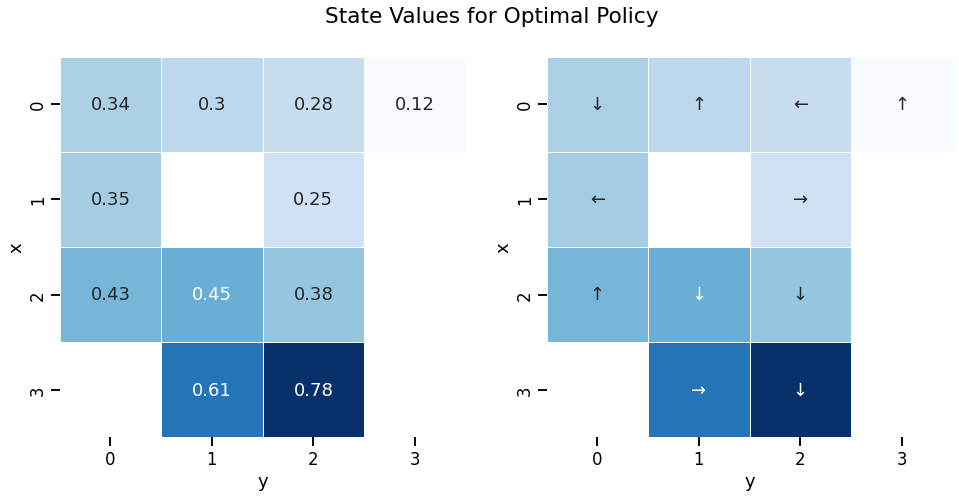

In [11]:
# Reshape Data
returns = optimal_policy.pivot("x", "y", "return")
direction = optimal_policy.pivot("x", "y", "label")

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16,7))
fig.suptitle('State Values for Optimal Policy')

sns.heatmap(returns, annot=True, linewidths=.5, cbar=False, cmap="Blues", ax=axes[0]);
sns.heatmap(returns, annot=np.array(direction), linewidths=.5, cbar=False, cmap="Blues", fmt = '', ax=axes[1]);

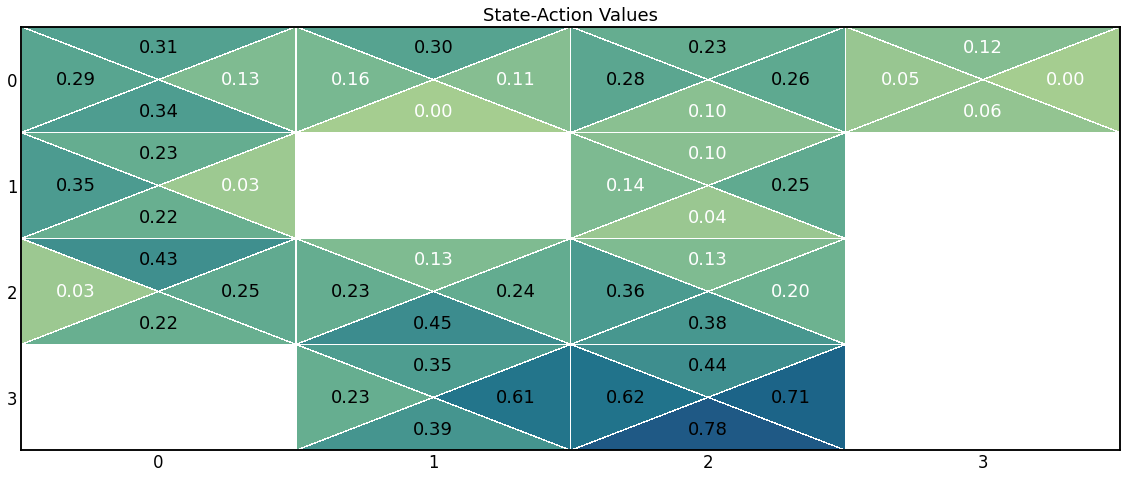

In [18]:
from matplotlib.tri import Triangulation

def triangulation_for_triheatmap(M, N):
    xv, yv = np.meshgrid(np.arange(-0.5, M), np.arange(-0.5, N))  # vertices of the little squares
    xc, yc = np.meshgrid(np.arange(0, M), np.arange(0, N))  # centers of the little squares
    x = np.concatenate([xv.ravel(), xc.ravel()])
    y = np.concatenate([yv.ravel(), yc.ravel()])
    cstart = (M + 1) * (N + 1)  # indices of the centers

    trianglesN = [(i + j * (M + 1), i + 1 + j * (M + 1), cstart + i + j * M)
                  for j in range(N) for i in range(M)]
    trianglesE = [(i + 1 + j * (M + 1), i + 1 + (j + 1) * (M + 1), cstart + i + j * M)
                  for j in range(N) for i in range(M)]
    trianglesS = [(i + 1 + (j + 1) * (M + 1), i + (j + 1) * (M + 1), cstart + i + j * M)
                  for j in range(N) for i in range(M)]
    trianglesW = [(i + (j + 1) * (M + 1), i + j * (M + 1), cstart + i + j * M)
                  for j in range(N) for i in range(M)]
    return [Triangulation(x, y, triangles) for triangles in [trianglesN, trianglesE, trianglesS, trianglesW]]


df = average_returns[~average_returns["state"].isin(terminal_states)].pivot(index=["x","y"], columns="label", values="return").reset_index()
df_piv = df.pivot_table(index='x', columns='y')

M = len(df_piv.columns) // 4
N = len(df_piv)
values = [df_piv[dir] for dir in
          ["↑", "→", "↓","←"]]  # these are the 4 column names in df

triangul = triangulation_for_triheatmap(M, N)
cmaps = ['crest'] * 4

norms = [plt.Normalize(0, 1) for _ in range(4)]
fig, ax = plt.subplots(figsize=(16, 7))
imgs = [ax.tripcolor(t, np.ravel(val), cmap=cmap, norm=norm, ec='white')
        for t, val, cmap, norm in zip(triangul, values, cmaps, norms)]


for val, dir in zip(values, [(-1, 0), (0, 1), (1, 0), (0, -1)]):
    for i in range(M):
        for j in range(N):
            v = val[i][j]
            ax.text(i + 0.3 * dir[1], j + 0.3 * dir[0], f'{v:.2f}', color='k' if 0.2 < v < 0.8 else 'w', ha='center', va='center')

ax.tick_params(length=0)
ax.set_xticks(range(M))
ax.set_xticklabels(df_piv["↑"].columns)
ax.set_yticks(range(N))
ax.set_yticklabels(df_piv.index)
ax.invert_yaxis()
ax.margins(x=0, y=0)

ax.set_title("State-Action Values")

plt.tight_layout()
plt.show()